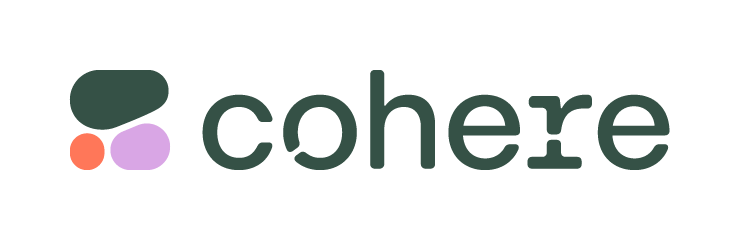

## Overview

Cohere chat models (Comand R and Command R+) are fantastic generally capable models out of the box. To further adopt our models for specific tasks, there are several strategies like prompt engineering, RAG, tool use, finetuning. In this notebook, we will focus on finetuning. While the other strategies involve careful and intelligent orchestration of our models out of the box, finetuning involves modifying the weights to specialize the model for a task at hand. This requires careful investment of time and resources from data collection to model training. This is typically employed when all other strategies fall short. Our finetuning service allows customization of our latest Command R model (command-r-08-2024) with LoRA based finetuning which gives users the the ability to control model flexibility depending on their task. Additionally, we extended the training context length to 16384 tokens giving users the ability to user longer training data points which is typical for RAG, agents, and tool use.

We will showcase model customization on the task of conversational financial question answering. Specifically, we finetune our model on [ConvFinQA](https://github.com/czyssrs/ConvFinQA) dataset. In this task, the output expected from the model is a domain specific language (DSL) that we will potentially feed into a downstream application. LLMs are known to be bad at arithmetics. Hence, instead of computing the answer, the task here is to extract the right numbers from the context and applying the right sequence of predicates and to strictly follow the DSL to ensure minimal error rates in the downstream application that may consume the DSL output from our model. Prompt engineering proves to be rather brittle for such tasks as it is hard to make sure the model follows the exact syntax of the DSL. Finetuning the model gives that guarantee.



## Setup

### Dependencies

If you dont already have [Cohere Python SDK](https://github.com/cohere-ai/cohere-python), you can install it as follows.

In [1]:
# ! pip install cohere

In [2]:
import os
import cohere
from cohere.finetuning import Hyperparameters, Settings, WandbConfig, FinetunedModel, BaseModel

os.environ['COHERE_API_KEY'] = "<COHERE_API_KEY>" # fill in your Cohere API key here

# instantiate the Cohere client
co = cohere.Client(os.environ['COHERE_API_KEY'])  

## Dataset

[ConvFinQA](https://github.com/czyssrs/ConvFinQA) dataset is a conversational dataset comprising of multi-turn numerical question and answers based on a given financial report which includes text and tables. We process the original dataset to do a few things:
- We preprocess the financial reports to combine various fields in the original dataset to create a single text blurb from which the questions are to be answered. This involves concatenating various pieces of text, converting the tables to simple text with heuristic regex mappings, among other cosmetic things.
- For finetuning Command R models, the dataset needs to be a `jsonl` file, where each `json` object is a conversation. Each conversation has a list of messages, and each message has two properties: role and content. The role identifies the sender (Chatbot, System, or User), while the content contains the text content. You can find more detailed guide on preparing the dataset including the data validations we have, train/eval splits we recommend, etc. [here](https://docs.cohere.com/docs/chat-preparing-the-data). We format the conversations in the original dataset to conform to these requirements.

### ConvFinQA data example

Following is an example datapoint from the finetuning data.

In [ ]:
{
    "messages": 
        [
            {"role": "System", "content": "stock-based awards under the plan stock options 2013 marathon grants stock options under the 2007 plan and previously granted options under the 2003 plan .\nmarathon 2019s stock options represent the right to purchase shares of common stock at the fair market value of the common stock on the date of grant .\nthrough 2004 , certain stock options were granted under the 2003 plan with a tandem stock appreciation right , which allows the recipient to instead elect to receive cash and/or common stock equal to the excess of the fair market value of shares of common stock , as determined in accordance with the 2003 plan , over the option price of the shares .\nin general , stock options granted under the 2007 plan and the 2003 plan vest ratably over a three-year period and have a maximum term of ten years from the date they are granted .\nstock appreciation rights 2013 prior to 2005 , marathon granted sars under the 2003 plan .\nno stock appreciation rights have been granted under the 2007 plan .\nsimilar to stock options , stock appreciation rights represent the right to receive a payment equal to the excess of the fair market value of shares of common stock on the date the right is exercised over the grant price .\nunder the 2003 plan , certain sars were granted as stock-settled sars and others were granted in tandem with stock options .\nin general , sars granted under the 2003 plan vest ratably over a three-year period and have a maximum term of ten years from the date they are granted .\nstock-based performance awards 2013 prior to 2005 , marathon granted stock-based performance awards under the 2003 plan .\nno stock-based performance awards have been granted under the 2007 plan .\nbeginning in 2005 , marathon discontinued granting stock-based performance awards and instead now grants cash-settled performance units to officers .\nall stock-based performance awards granted under the 2003 plan have either vested or been forfeited .\nas a result , there are no outstanding stock-based performance awards .\nrestricted stock 2013 marathon grants restricted stock and restricted stock units under the 2007 plan and previously granted such awards under the 2003 plan .\nin 2005 , the compensation committee began granting time-based restricted stock to certain u.s.-based officers of marathon and its consolidated subsidiaries as part of their annual long-term incentive package .\nthe restricted stock awards to officers vest three years from the date of grant , contingent on the recipient 2019s continued employment .\nmarathon also grants restricted stock to certain non-officer employees and restricted stock units to certain international employees ( 201crestricted stock awards 201d ) , based on their performance within certain guidelines and for retention purposes .\nthe restricted stock awards to non-officers generally vest in one-third increments over a three-year period , contingent on the recipient 2019s continued employment .\nprior to vesting , all restricted stock recipients have the right to vote such stock and receive dividends thereon .\nthe non-vested shares are not transferable and are held by marathon 2019s transfer agent .\ncommon stock units 2013 marathon maintains an equity compensation program for its non-employee directors under the 2007 plan and previously maintained such a program under the 2003 plan .\nall non-employee directors other than the chairman receive annual grants of common stock units , and they are required to hold those units until they leave the board of directors .\nwhen dividends are paid on marathon common stock , directors receive dividend equivalents in the form of additional common stock units .\nstock-based compensation expense 2013 total employee stock-based compensation expense was $ 80 million , $ 83 million and $ 111 million in 2007 , 2006 and 2005 .\nthe total related income tax benefits were $ 29 million , $ 31 million and $ 39 million .\nin 2007 and 2006 , cash received upon exercise of stock option awards was $ 27 million and $ 50 million .\ntax benefits realized for deductions during 2007 and 2006 that were in excess of the stock-based compensation expense recorded for options exercised and other stock-based awards vested during the period totaled $ 30 million and $ 36 million .\ncash settlements of stock option awards totaled $ 1 million and $ 3 million in 2007 and 2006 .\nstock option awards granted 2013 during 2007 , 2006 and 2005 , marathon granted stock option awards to both officer and non-officer employees .\nthe weighted average grant date fair value of these awards was based on the following black-scholes assumptions: .\nThe weighted average exercise price per share of 2007, 2006, 2005 are $ 60.94, $ 37.84, $ 25.14. The expected annual dividends per share of 2007, 2006, 2005 are $ 0.96, $ 0.80, $ 0.66. The expected life in years of 2007, 2006, 2005 are 5.0, 5.1, 5.5. The expected volatility of 2007, 2006, 2005 are 27% ( 27 % ), 28% ( 28 % ), 28% ( 28 % ). The risk-free interest rate of 2007, 2006, 2005 are 4.1% ( 4.1 % ), 5.0% ( 5.0 % ), 3.8% ( 3.8 % ). The weighted average grant date fair value of stock option awards granted of 2007, 2006, 2005 are $ 17.24, $ 10.19, $ 6.15.\n."}, 
            {"role": "User", "content": "what was the weighted average exercise price per share in 2007?"}, 
            {"role": "Chatbot", "content": "60.94"}, 
            {"role": "User", "content": "and what was it in 2005?"}, 
            {"role": "Chatbot", "content": "25.14"}, 
            {"role": "User", "content": "what was, then, the change over the years?"}, 
            {"role": "Chatbot", "content": "subtract(60.94, 25.14)"}, 
            {"role": "User", "content": "what was the weighted average exercise price per share in 2005?"}, 
            {"role": "Chatbot", "content": "25.14"}, 
            {"role": "User", "content": "and how much does that change represent in relation to this 2005 weighted average exercise price?"}, 
            {"role": "Chatbot", "content": "subtract(60.94, 25.14), divide(#0, 25.14)"}
        ]
}

As you can see, the financial report based on which we answer the questions is put in as System role. This acts as the 'system prompt', which is part of the prompt used as context/instructions for the entire conversation. Since the information in the report is required and relevant to every user question in the conversation, we would want to put it as the overall context of the conversation.

Few things to note in the above example:
- Models trained via our finetuning API do not have any additional/default preamble other than the system prompt provided in the finetuning dataset. 
- Each datapoint has multiple turns alternating between `User` and `Chatbot`; during finetuning, we consume messages from all roles but only the `Chatbot` messages contribute to the model updtates.
- We want the model to learn to strictly follow the domain specific language as represented by the desired Chatbot responses in this example.

### Upload the dataset

We use the [Datasets API](https://docs.cohere.com/reference/create-dataset) to upload the dataset required for finetuning. Note that we upload both training and evaluation files. The data in evaluation file is used for validation and early stopping as we will elaborate later.

In [ ]:
chat_dataset = co.datasets.create(name="cfqa-ft-dataset",
                                   data=open("data/convfinqa-train-chat.jsonl", "rb"),
                                   eval_data=open("data/convfinqa-eval-chat.jsonl", "rb"),
                                   type="chat-finetune-input")
print(chat_dataset.id) # we will use this id to refer to the dataset when creating a finetuning job


Whenever a dataset is created, the data is validated asynchronously. This validation is kicked off automatically on the backend, and must be completed before we can use this dataset for finetuning. You can find more info on interpreting the errors, if you get any, [here](https://docs.cohere.com/docs/datasets#dataset-validation).

In [ ]:
co.wait(chat_dataset) # wait for the dataset to be processed and validated

## Start finetuning

Once the dataset is validated, we can start a finetuning job with the [Finetuning API](https://docs.cohere.com/reference/createfinetunedmodel).

### Hyperparameters

There are several hyperparameters that you can modify to get the most out of your finetuning. You can find detailed explanation [here](https://docs.cohere.com/reference/createfinetunedmodel#request.body.settings.hyperparameters).

In [22]:
hp_config = Hyperparameters(
  train_batch_size=16,
  train_epochs=1,
  learning_rate=0.0001,
)

### WandB integration

For chat finetuning, we support WandB integration which allows you to monitor the loss curves of finetuning jobs in real-time without having to wait for the job to finish. You can find more info [here](https://docs.cohere.com/reference/createfinetunedmodel#request.body.settings.wandb).

In [23]:
wnb_config = WandbConfig(
    project="test-project",
    api_key="<wandb_api_key>",
    entity="test-entity", # must be a valid enitity associated with the provided API key
)

### Create the finetuning job

With the dataset, hyperparameters, and the wandb configurations ready, we can create a fientuning job as follows. You can find the details of all params in the [Finetuning API](https://docs.cohere.com/reference/createfinetunedmodel#request) documentation.

In [ ]:
cfqa_finetune = co.finetuning.create_finetuned_model(
  request=FinetunedModel(
    name="cfqa-command-r-ft",
    settings=Settings(
      base_model=BaseModel(
        base_type="BASE_TYPE_CHAT", # specifies this is a chat finetuning
      ),
      dataset_id=chat_dataset.id, # the id of the dataset we created above
      hyperparameters=hp_config,
      wandb=wnb_config,
    ),
  ),
)
print(cfqa_finetune.finetuned_model.id) # we will use this id to refer to the finetuned model when making predictions/getting status/etc.

## Check finetuning status

Once the finetuning job finishes and the finetuned model is ready to use, you will get notified via email. Or you can check of the status of your finetuning job as follows.

In [ ]:
response = co.finetuning.get_finetuned_model(cfqa_finetune.finetuned_model.id)
print(response.finetuned_model.status) # when the job finished this will be STATUS_READY

You may view the fine-tuning job loss curves via the Weights and Biases dashboard. It will be available via the following URL once the training starts: https://wandb.ai/[your-entity]/[your-project]/runs/[finetuned-model-id]. We log the following to WandB:
- training loss at every training step
- validation loss and accuracy (as described [here](https://docs.cohere.com/docs/chat-understanding-the-results)) at every validation step

For this particular fientuning job, the traning loss, validation loss and validation accuracy should look as follows.
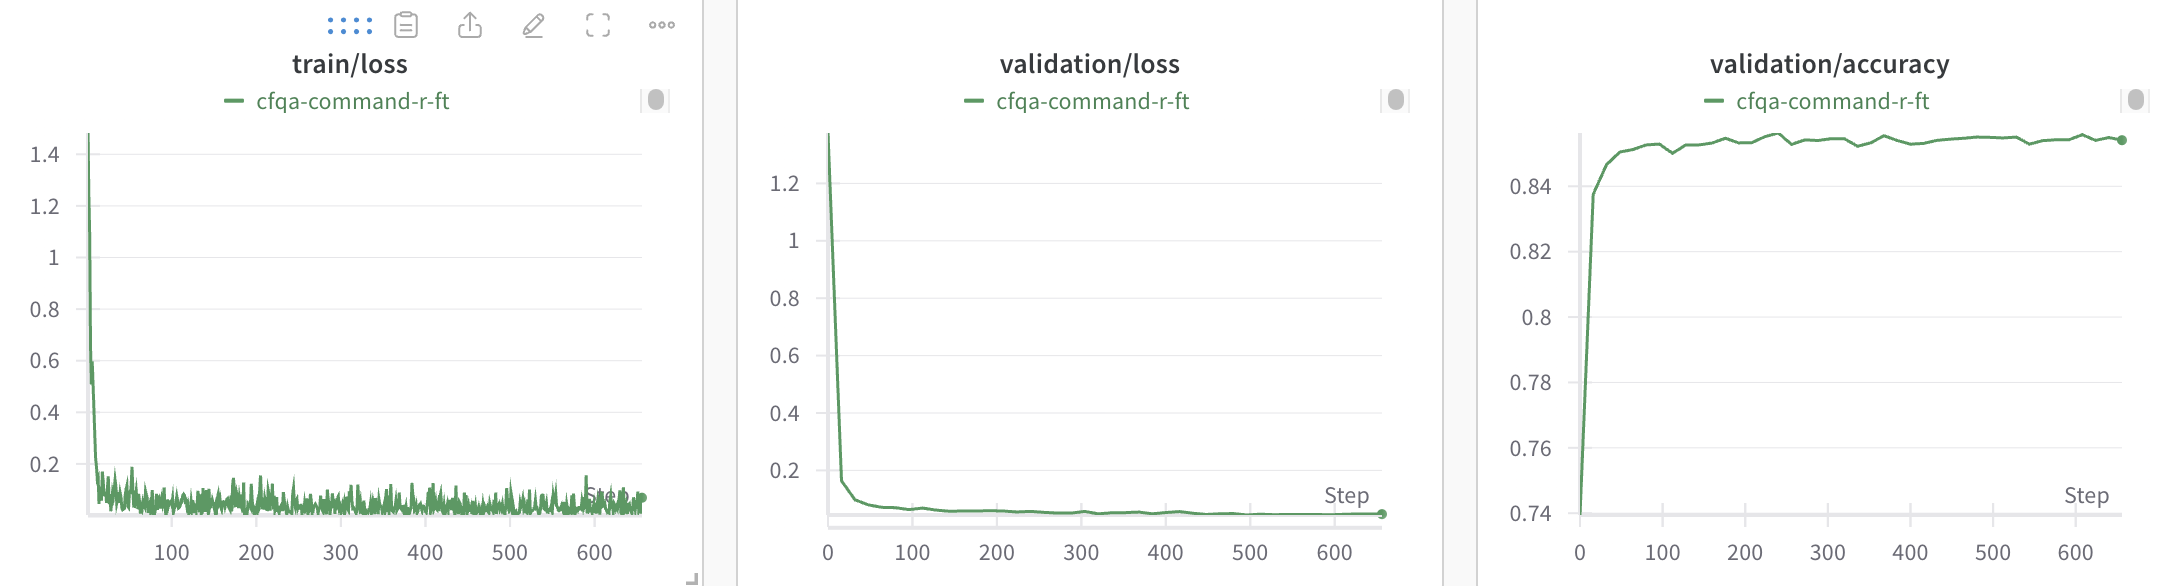

Once the training job finished you can also check the validation metrics as follows.

In [ ]:
train_step_metrics = co.finetuning.list_training_step_metrics(
    finetuned_model_id=cfqa_finetune.finetuned_model.id)

for metric in train_step_metrics.step_metrics:
    print(metric.metrics)

## Run inference with the finetuned model

Once your model completes training, you can call it via co.chat() and pass your custom model id. Please note, the model id is the id returned by the fine-tuned model object + `-ft` suffix. `co.chat()` uses no preamble by default for fine-tuned models. You can specify a preamble using the preamble parameter, if you like. In this case, we wont specify any preamble and follow the convention set in the training data.

In [46]:
response = co.chat(
  message="what was the total african and us net undeveloped acres expiring in 2016?",
  chat_history=[
    {"role": "System", "message": "in the ordinary course of business , based on our evaluations of certain geologic trends and prospective economics , we have allowed certain lease acreage to expire and may allow additional acreage to expire in the future .\nif production is not established or we take no other action to extend the terms of the leases , licenses or concessions , undeveloped acreage listed in the table below will expire over the next three years .\nwe plan to continue the terms of certain of these licenses and concession areas or retain leases through operational or administrative actions ; however , the majority of the undeveloped acres associated with other africa as listed in the table below pertains to our licenses in ethiopia and kenya , for which we executed agreements in 2015 to sell .\nthe kenya transaction closed in february 2016 and the ethiopia transaction is expected to close in the first quarter of 2016 .\nsee item 8 .\nfinancial statements and supplementary data - note 5 to the consolidated financial statements for additional information about this disposition .\nnet undeveloped acres expiring year ended december 31 .\nThe u.s . of net undeveloped acres expiring year ended december 31 , 2016, net undeveloped acres expiring year ended december 31 , 2017, net undeveloped acres expiring year ended december 31 , 2018 are 68, 89, 128. The e.g . of net undeveloped acres expiring year ended december 31 , 2016, net undeveloped acres expiring year ended december 31 , 2017, net undeveloped acres expiring year ended december 31 , 2018 are 2014, 92, 36. The other africa of net undeveloped acres expiring year ended december 31 , 2016, net undeveloped acres expiring year ended december 31 , 2017, net undeveloped acres expiring year ended december 31 , 2018 are 189, 4352, 854. The total africa of net undeveloped acres expiring year ended december 31 , 2016, net undeveloped acres expiring year ended december 31 , 2017, net undeveloped acres expiring year ended december 31 , 2018 are 189, 4444, 890. The other international of net undeveloped acres expiring year ended december 31 , 2016, net undeveloped acres expiring year ended december 31 , 2017, net undeveloped acres expiring year ended december 31 , 2018 are 2014, 2014, 2014. The total of net undeveloped acres expiring year ended december 31 , 2016, net undeveloped acres expiring year ended december 31 , 2017, net undeveloped acres expiring year ended december 31 , 2018 are 257, 4533, 1018.\n."}, 
    {"role": "User", "message": "what percentage of undeveloped acres were in the us in 2018?"}, 
    {"role": "Chatbot", "message": "divide(128, 1018)"} 
    # {"role": "User", "message": "what was the total african and us net undeveloped acres expiring in 2016?"}, # this is input as the main query above
    # {"role": "Chatbot", "message": "add(189, 68)"}, # this is the ground truth answer
  ],
  model=cfqa_finetune.finetuned_model.id+"-ft"
)
print(response.text)

add(189, 68)


The response object is described in detail [here](https://docs.cohere.com/reference/chat#response). As you can see, the finetuned model responds in the DSL as expected and matches the ground truth. This DSL response can now be consumed by any downstream application or engine that can compute the final answer. For a comparison we show the base model response to the same inputs.

In [43]:
base_response = co.chat(
  message="what was the total african and us net undeveloped acres expiring in 2016?",
  chat_history=[
    {"role": "System", "message": "in the ordinary course of business , based on our evaluations of certain geologic trends and prospective economics , we have allowed certain lease acreage to expire and may allow additional acreage to expire in the future .\nif production is not established or we take no other action to extend the terms of the leases , licenses or concessions , undeveloped acreage listed in the table below will expire over the next three years .\nwe plan to continue the terms of certain of these licenses and concession areas or retain leases through operational or administrative actions ; however , the majority of the undeveloped acres associated with other africa as listed in the table below pertains to our licenses in ethiopia and kenya , for which we executed agreements in 2015 to sell .\nthe kenya transaction closed in february 2016 and the ethiopia transaction is expected to close in the first quarter of 2016 .\nsee item 8 .\nfinancial statements and supplementary data - note 5 to the consolidated financial statements for additional information about this disposition .\nnet undeveloped acres expiring year ended december 31 .\nThe u.s . of net undeveloped acres expiring year ended december 31 , 2016, net undeveloped acres expiring year ended december 31 , 2017, net undeveloped acres expiring year ended december 31 , 2018 are 68, 89, 128. The e.g . of net undeveloped acres expiring year ended december 31 , 2016, net undeveloped acres expiring year ended december 31 , 2017, net undeveloped acres expiring year ended december 31 , 2018 are 2014, 92, 36. The other africa of net undeveloped acres expiring year ended december 31 , 2016, net undeveloped acres expiring year ended december 31 , 2017, net undeveloped acres expiring year ended december 31 , 2018 are 189, 4352, 854. The total africa of net undeveloped acres expiring year ended december 31 , 2016, net undeveloped acres expiring year ended december 31 , 2017, net undeveloped acres expiring year ended december 31 , 2018 are 189, 4444, 890. The other international of net undeveloped acres expiring year ended december 31 , 2016, net undeveloped acres expiring year ended december 31 , 2017, net undeveloped acres expiring year ended december 31 , 2018 are 2014, 2014, 2014. The total of net undeveloped acres expiring year ended december 31 , 2016, net undeveloped acres expiring year ended december 31 , 2017, net undeveloped acres expiring year ended december 31 , 2018 are 257, 4533, 1018.\n."}, 
    {"role": "User", "message": "what percentage of undeveloped acres were in the us in 2018?"}, 
    {"role": "Chatbot", "message": "divide(128, 1018)"} 
    # {"role": "User", "message": "what was the total african and us net undeveloped acres expiring in 2016?"}, # this is input as the main query above
    # {"role": "Chatbot", "message": "add(189, 68)"}, # this is the ground truth answer
  ],
  model="command-r-08-2024"
)
print(base_response.text)

The total African undeveloped acres expiring in 2016 is 189 acres, while the US undeveloped acres expiring in the same year is 68 acres. 

Adding these together gives a total of 257 acres.


As you can see, the base model is pretty good in itself. The final answer is correct, in this particular instance (189 + 68 = 257). However, this model response needs further processing to extract the final answer. This post processing can be a noisy process. Also, please note that the LLM's ability for complex numerical reasoning is not very reliable. For these reasons, finetuning it to output DSL is a much more reliable and interpretable way to arrive at the final answer.